In [1]:
import os
import sys
import subprocess
import shutil
import pandas as pd
import numpy as np
import xmltodict
import json
import hashlib
from EPEutils import *

import matplotlib
import matplotlib.pyplot as plt
from pandas.plotting import table

HOMEDIR="."


In [2]:
xmlfilelst = [fn for fn in os.listdir(".") if '.ntx' in fn]
print(xmlfilelst)

['MobileNetworkConditions_from_(40.44,-79.94)_to_128.2.209.144_02_11_2020_1534.ntx', 'MobileNetworkConditions_from_(40.44,-79.94)_to_128.2.209.144_02_11_2020_1536.ntx', 'MobileNetworkConditions_from_(40.44,-79.94)_to_128.2.209.144_02_11_2020_1539.ntx', 'MobileNetworkConditions_from_(40.44,-79.94)_to_128.2.209.144_02_11_2020_1612.ntx']


In [60]:
''' Converting XML to DataFrame '''
def parseXML(pdata):
    ''' Parse xml data '''
    perfdata2 = pdata['NETWOR_X']['RECORDING_DATA']['DATA_BLOCK']
    latandloss = dict(perfdata2[0]['LATENCY_AND_LOSS_DATA'])
    bandwidth = dict(perfdata2[1]['BW_DATA'])
    return perfdata2,latandloss,bandwidth

''' Convert xml data to dataframes '''
def convertXML2DF(latandloss,bandwidth):
    cols = ['LAT','LOS','BW']
    tmpdf = pd.DataFrame(list(zip(latandloss['LAT'],latandloss['LOS'],bandwidth['BW'])),columns=cols)
    for col in cols:
        tmpdf[col] = pd.to_numeric(tmpdf[col],errors='coerce')
    tmpdf['HASH'] = xmlfile_detail['HASH']
#     dumpdf(tmpdf)
    return tmpdf

In [66]:
destdict = {'128.2.209.144':'cloudlet012-CMU'}
detaildict = {
    'MobileNetworkConditions_from_(40.44,-79.94)_to_128.2.209.144_02_11_2020_1534.ntx':{
        'Title':'Title1',
        'Carrier':'T-Mobile','Connect':'LTE','TIMESTAMP':'02_11_2020_1534',
        'LOC':(40.44,-79.94),'DEST':destdict['128.2.209.144'],'DEVICE':'Essential PH-1'
    },
    'MobileNetworkConditions_from_(40.44,-79.94)_to_128.2.209.144_02_11_2020_1536.ntx':{
        'Title':'Title2',
        'Carrier':'Verizon','Connect':'LTE','TIMESTAMP':'02_11_2020_1536',
        'LOC':(40.44,-79.94),'DEST':destdict['128.2.209.144'],'DEVICE':'Galaxy S8'
    }, 
    'MobileNetworkConditions_from_(40.44,-79.94)_to_128.2.209.144_02_11_2020_1539.ntx':{
        'Title':'Title3',
        'Carrier':'T-Mobile','Connect':'WiFi','TIMESTAMP':'02_11_2020_1539',
        'LOC':(40.44,-79.94),'DEST':destdict['128.2.209.144'],'DEVICE':'Essential PH-1'
    }, 
    'MobileNetworkConditions_from_(40.44,-79.94)_to_128.2.209.144_02_11_2020_1612.ntx':{
        'Title':'Title4',
        'Carrier':'Verizon','Connect':'WiFi','TIMESTAMP':'02_11_2020_1612',
        'LOC':(40.44,-79.94),'DEST':destdict['128.2.209.144'],'DEVICE':'Galaxy S8'
    }
}
keylst = detaildict.keys()
for key in keylst:
    dtl = detaildict[key]
    title = "TIME-NETWORK: %s %s %s \nDEVICE: %s\nLOCATION: @(%f,%f) to %s" % \
            (dtl['TIMESTAMP'],dtl['Carrier'],dtl['Connect'],dtl['DEVICE'],dtl['LOC'][0],dtl['LOC'][1],dtl['DEST'])
    hashstr = hashlib.md5(title.encode()).hexdigest()
    detaildict[key]['Title'] = title
    detaildict[key]['HASH'] = hashstr
    detaildict[key]['fname'] = key
#     print(title,hashstr)
print(detaildict)
with open('detaildict.json', 'w') as fp:
    json.dump(detaildict, fp, indent=4)

{'MobileNetworkConditions_from_(40.44,-79.94)_to_128.2.209.144_02_11_2020_1534.ntx': {'Title': 'TIME-NETWORK: 02_11_2020_1534 T-Mobile LTE \nDEVICE: Essential PH-1\nLOCATION: @(40.440000,-79.940000) to cloudlet012-CMU', 'Carrier': 'T-Mobile', 'Connect': 'LTE', 'TIMESTAMP': '02_11_2020_1534', 'LOC': (40.44, -79.94), 'DEST': 'cloudlet012-CMU', 'DEVICE': 'Essential PH-1', 'HASH': '60095abb93ab068d17ba155c84ec2be1', 'fname': 'MobileNetworkConditions_from_(40.44,-79.94)_to_128.2.209.144_02_11_2020_1534.ntx'}, 'MobileNetworkConditions_from_(40.44,-79.94)_to_128.2.209.144_02_11_2020_1536.ntx': {'Title': 'TIME-NETWORK: 02_11_2020_1536 Verizon LTE \nDEVICE: Galaxy S8\nLOCATION: @(40.440000,-79.940000) to cloudlet012-CMU', 'Carrier': 'Verizon', 'Connect': 'LTE', 'TIMESTAMP': '02_11_2020_1536', 'LOC': (40.44, -79.94), 'DEST': 'cloudlet012-CMU', 'DEVICE': 'Galaxy S8', 'HASH': 'e61aaa491d5696b0048f9a6abbc3bf34', 'fname': 'MobileNetworkConditions_from_(40.44,-79.94)_to_128.2.209.144_02_11_2020_1536.

In [67]:
''' Read the files into dataframes '''
''' dflst is a list of dataframes -- one for each file '''
keylst = list(detaildict.keys())
dflst = []
for xmlfile in keylst:
    xmlfile_detail = detaildict[xmlfile]
    if os.path.isfile(xmlfile):
        with open(xmlfile) as f:
            perfdata = xmltodict.parse(f.read())
    else:
        print(xmlfile, " does not exist")
        continue
    perfdata2,latandloss,bandwidth = parseXML(perfdata)
    dflst.append((xmlfile_detail,convertXML2DF(latandloss,bandwidth).reset_index().rename({'index':'count'},axis=1)))
    


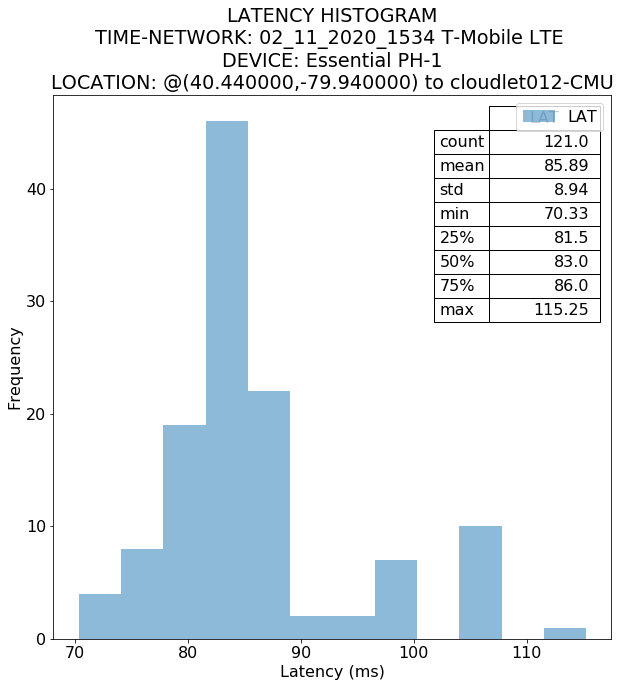

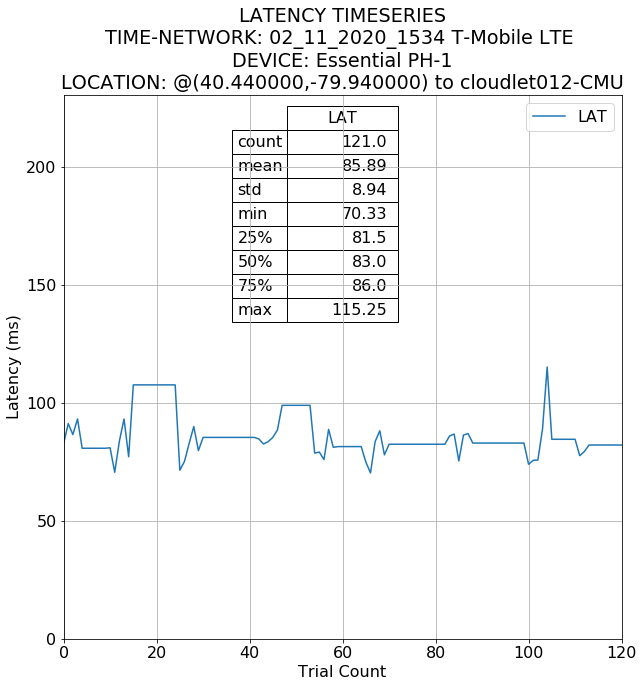

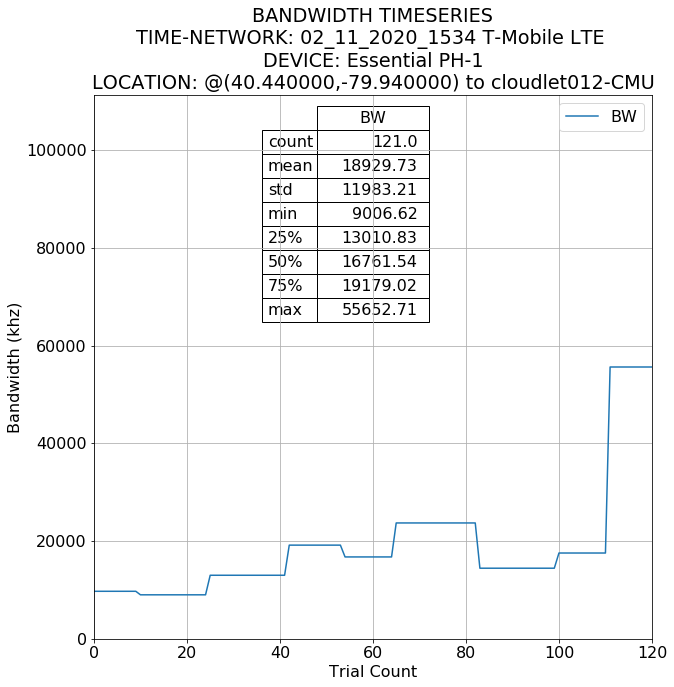

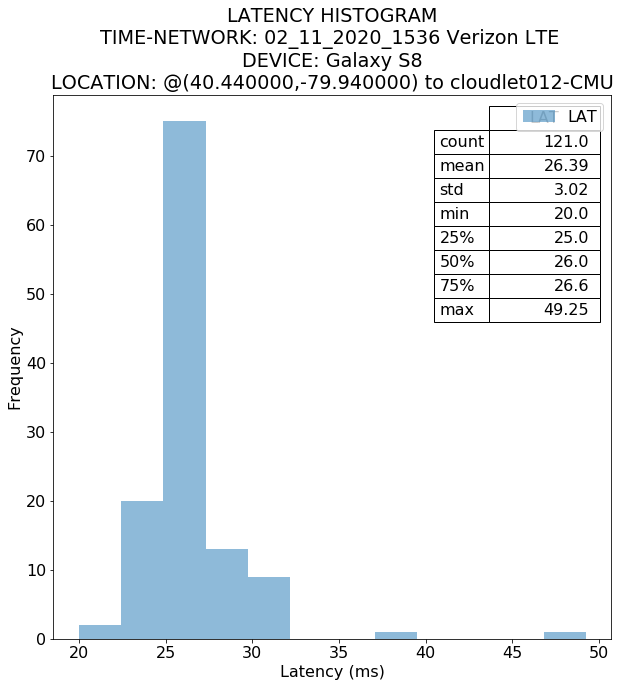

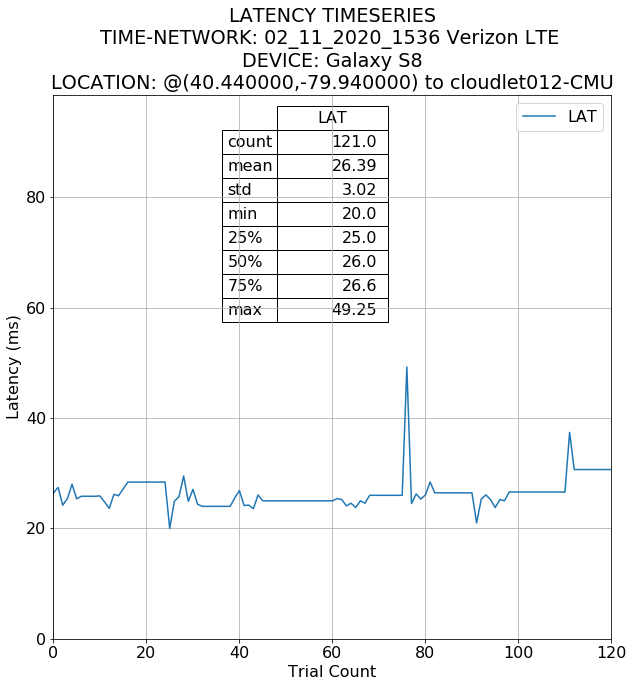

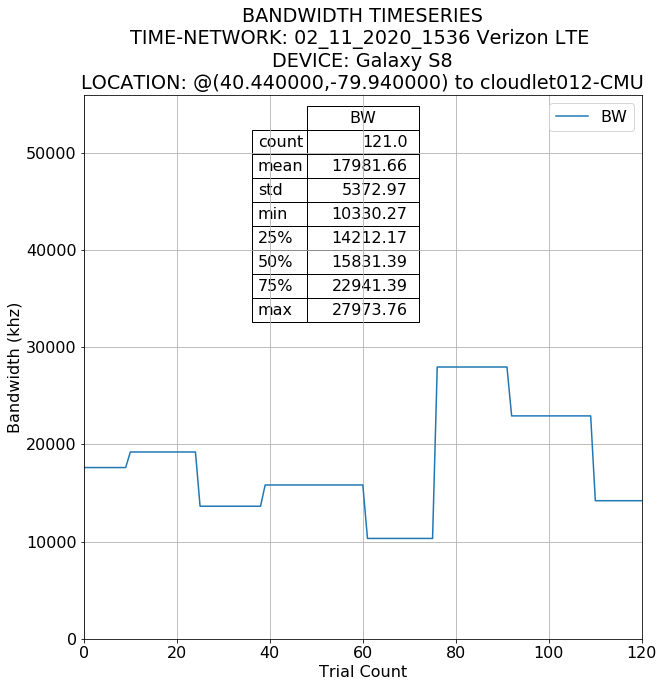

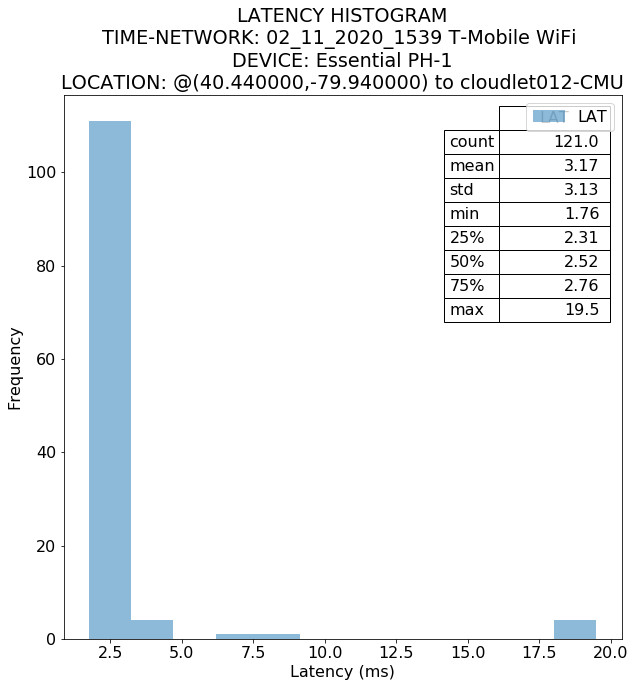

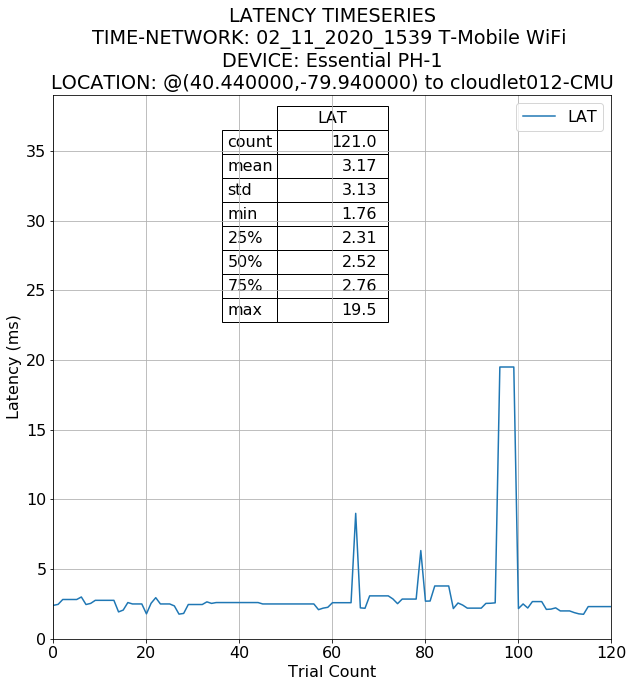

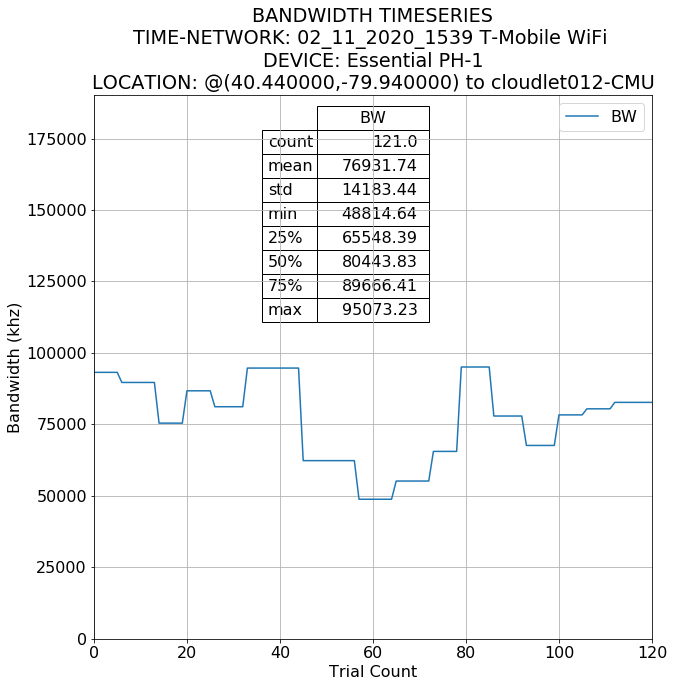

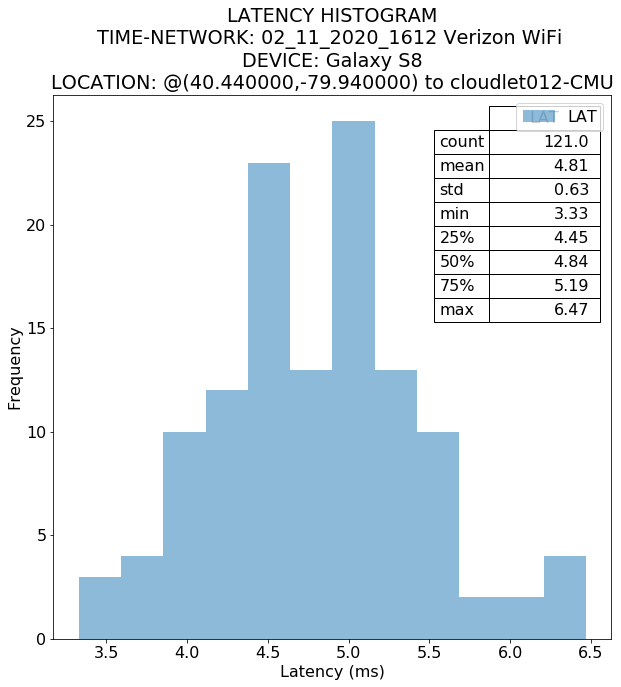

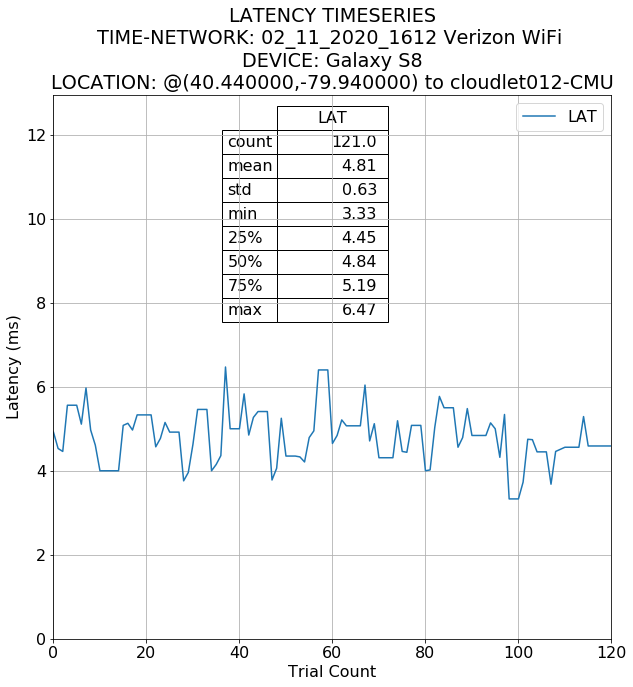

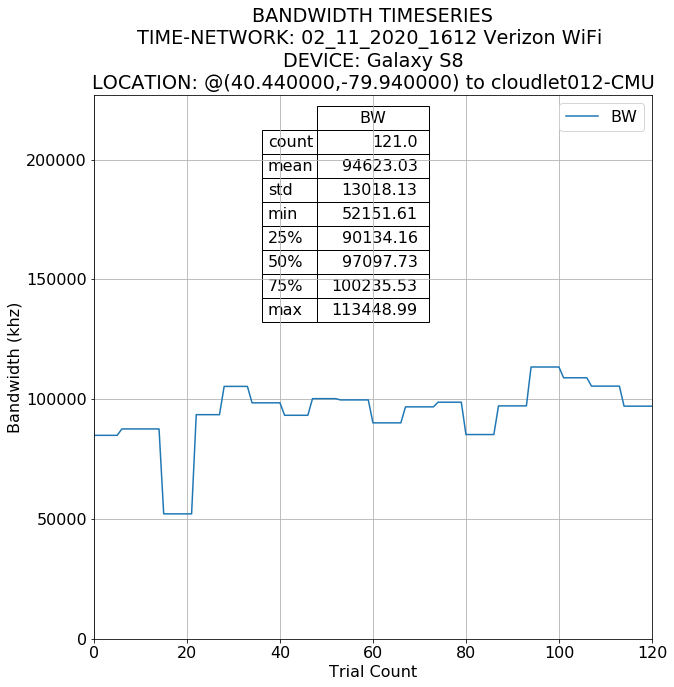

In [68]:
defargs = {
    'figsize':(10,10),
    'fontsize':16,
    'saveon':False,
    'crs':{'init':'epsg:4326'},
    'markersize':3,
    'histalpha':0.5,
    'histbins':10,
    'tabfontsize':16,
    'tabscale':(1,2)
}
args = defargs

plt.rcParams.update({'font.size': args['fontsize']})

def save_plot(ax,fname):
    if args['saveon']:
        ax.get_figure().savefig(os.path.join(HOMEDIR,fname))
        
def ts_lineplot(tmpdf,ylst,titl,fname):
    print(titl)
    ax = tmpdf.reset_index().plot(x='TIMESTAMP',y = ylst,title=titl,figsize=args['figsize'])
    ax.grid(True)
    if args['saveon']:
        save_plot(ax,fname)
    return ax

def lineplot(tmpdf,xcol,ylst,**kwargs):
    ''' Parameters '''
    title = kwargs['title'] if 'title' in kwargs else 'Unknown Title'
    figsize = kwargs['figsize'] if 'figsize' in kwargs else args['figsize']
    fn = kwargs['filename'] if 'filename' in kwargs else 'tmp.png'
    xlabel = kwargs['xlabel'] if 'xlabel' in kwargs else ''
    ylabel = kwargs['ylabel'] if 'ylabel' in kwargs else ''
    
    ''' PLot '''
    ymax = list(tmpdf[ylst].max())[0]
    ylim = ymax*2
    ax = tmpdf.reset_index().plot(x=xcol,y=ylst,title=title,figsize=figsize,ylim=(0,ylim))
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid(True)
    tabcolWidths = [0.2 for col in range(0,len(ylst))]
    tab = table(ax,np.round(tmpdf[ylst].describe(),2),loc='upper center',colWidths=tabcolWidths)
    tab.set_fontsize(args['tabfontsize'])
    tab.scale(args['tabscale'][0],args['tabscale'][1])
    if args['saveon']:
        save_plot(ax,fn)
    return ax

def histplot(dfin, **kwargs):
    df = pd.DataFrame(dfin) # in case actually a series
    ''' Parameters '''
    binct = kwargs['bins'] if 'bins' in kwargs else args['histbins']
    alph = kwargs['alpha'] if 'alpha' in kwargs else args['histalpha']
    titl = kwargs['title'] if 'title' in kwargs else 'Unknown Title'
    figsze = kwargs['figsize'] if 'figsize' in kwargs else args['figsize']
    fn = kwargs['filename'] if 'filename' in kwargs else 'tmp.png'
    xlabel = kwargs['xlabel'] if 'xlabel' in kwargs else ''
    bycol = kwargs['by'] if 'by' in kwargs else 'LAT'
    
    ''' Plot '''
    ax = df.plot.hist(bins=binct,alpha=alph,title=titl,figsize=figsze,by=bycol)
    ax.set_xlabel(xlabel)
    tabcolWidths = [0.2]
    tab = table(ax,np.round(df.describe(),2),loc='upper right',colWidths=tabcolWidths)
    tab.set_fontsize(args['tabfontsize'])
    tab.scale(args['tabscale'][0],args['tabscale'][1])
    if args['saveon']:
        save_plot(ax,fn)
    return ax

for dftup in dflst:
    dfdata = dftup[0]
#     print(dfdata)
    filebase = dfdata['fname'].replace('.ntx','_<TOKEN>.png')
    titl = dfdata['Title']
    df = dftup[1]
    filename = filebase.replace('<TOKEN>','LAT_HIST')
    histplot(df['LAT'],by='LAT',bins = int(len(df)/10),
        title='LATENCY HISTOGRAM\n%s' % titl,filename=filename,
        xlabel='Latency (ms)')
    filename = filebase.replace('<TOKEN>','LAT_LINE')
    lineplot(df,'count',['LAT'],title = 'LATENCY TIMESERIES\n%s' % titl, 
             xlabel='Trial Count',ylabel='Latency (ms)',filename=filename)
    filename = filebase.replace('<TOKEN>','BW_LINE')
    lineplot(df,'count',['BW'],title = 'BANDWIDTH TIMESERIES\n%s' % titl, 
             xlabel='Trial Count',ylabel='Bandwidth (khz)',filename=filename)
